# Result analysis of national SIRDS simulations

In [1]:
import os
from datetime import datetime

import numpy as np
from matplotlib import pyplot as plt
from sirds_model import brazil_covid_sirds_model, get_new_deaths, get_effective_reproduction_number, get_new_cases
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import util

In [2]:
filter_file = 'df_differential_evolution_national_days_to_recovery_'

## Reading data

In [3]:
df = pd.read_csv('data/output/df_ts_covid_brazil.csv')
df.DATA = pd.to_datetime(df.DATA, infer_datetime_format=True)

In [4]:
df['TAXA_CASOS_ACUMULADOS'] = df.CASOS / df.POPULACAO_ESTIMADA * 100000
df['TAXA_OBITOS_ACUMULADOS'] = df.OBITOS / df.POPULACAO_ESTIMADA * 100000
df

,DATA,SIGLA_ESTADO,MUNICIPIO,CODIGO_MUNICIPIO_7,OBITOS_NOVOS,OBITOS,CASOS_NOVOS,CASOS,POPULACAO_ESTIMADA,OBITOS_NOVOS_MEDIA_14_DIAS,...,TAXA_CASOS_NOVOS_MEDIA_14_DIAS,TAXA_CASOS_NOVOS_MEDIA_56_DIAS,TAXA_FATALIDADE,NUMERO_REPRODUCAO_EFETIVO_MEDIA,NUMERO_REPRODUCAO_EFETIVO_VARIANCIA,NUMERO_REPRODUCAO_EFETIVO_QUANTIL_0.025,NUMERO_REPRODUCAO_EFETIVO_MEDIANA,NUMERO_REPRODUCAO_EFETIVO_QUANTIL_0.975,TAXA_CASOS_ACUMULADOS,TAXA_OBITOS_ACUMULADOS
0,2020-02-25,TOTAL,TOTAL,0,0,0,1,1,210147125,0.000000,...,0.000476,0.000476,NaN,NaN,NaN,NaN,NaN,NaN,0.000476,0.000000
1,2020-02-26,TOTAL,TOTAL,0,0,0,0,1,210147125,0.000000,...,0.000238,0.000238,NaN,NaN,NaN,NaN,NaN,NaN,0.000476,0.000000
2,2020-02-27,TOTAL,TOTAL,0,0,0,0,1,210147125,0.000000,...,0.000159,0.000159,NaN,NaN,NaN,NaN,NaN,NaN,0.000476,0.000000
3,2020-02-28,TOTAL,TOTAL,0,0,0,1,2,210147125,0.000000,...,0.000238,0.000238,NaN,NaN,NaN,NaN,NaN,NaN,0.000952,0.000000
4,2020-02-29,TOTAL,TOTAL,0,0,0,0,2,210147125,0.000000,...,0.000190,0.000190,NaN,NaN,NaN,NaN,NaN,NaN,0.000952,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
959,2022-10-11,TOTAL,TOTAL,0,86,686963,7350,34731539,210147125,77.285714,...,2.887841,4.505848,1.058708,NaN,NaN,NaN,NaN,NaN,16527.249183,326.896216
960,2022-10-12,TOTAL,TOTAL,0,63,687026,5114,34736653,210147125,78.500000,...,2.802900,4.362981,1.153346,NaN,NaN,NaN,NaN,NaN,16529.682716,326.926195
961,2022-10-13,TOTAL,TOTAL,0,43,687069,3212,34739865,210147125,77.928571,...,2.587779,4.201912,1.149655,NaN,NaN,NaN,NaN,NaN,16531.211169,326.946657
962,2022-10-14,TOTAL,TOTAL,0,75,687144,6597,34746462,210147125,79.142857,...,2.513137,4.097682,1.185800,NaN,NaN,NaN,NaN,NaN,16534.350399,326.982346


In [5]:
valleys = []

with open('data/output/valleys.csv', "r") as file:
    for line in file:
        date_str = line.strip()
        date = datetime.strptime(date_str, "%Y-%m-%d").date()
        valleys.append(date)

## Selecting the best results

In [6]:
def get_sirds(result):
    y = brazil_covid_sirds_model(initial_infected_population=result.initial_infected_population,
                                 period_in_days=result.period_in_days,
                                 days_between_infections_0=result.days_between_infections_0,
                                 days_to_recovery_0=result.days_to_recovery_0,
                                 case_fatality_probability_0=result.case_fatality_probability_0,
                                 loss_immunity_in_days_0=result.loss_immunity_in_days_0,
                                 breakpoint_1=result.breakpoint_1,
                                 days_between_infections_1=result.days_between_infections_1,
                                 days_to_recovery_1=result.days_to_recovery_1,
                                 case_fatality_probability_1=result.case_fatality_probability_1,
                                 loss_immunity_in_days_1=result.loss_immunity_in_days_1,
                                 breakpoint_2=result.breakpoint_2,
                                 days_between_infections_2=result.days_between_infections_2,
                                 days_to_recovery_2=result.days_to_recovery_2,
                                 case_fatality_probability_2=result.case_fatality_probability_2,
                                 loss_immunity_in_days_2=result.loss_immunity_in_days_2,
                                 breakpoint_3=result.breakpoint_3,
                                 days_between_infections_3=result.days_between_infections_3,
                                 days_to_recovery_3=result.days_to_recovery_3,
                                 case_fatality_probability_3=result.case_fatality_probability_3,
                                 loss_immunity_in_days_3=(result.loss_immunity_in_days_0 + result.loss_immunity_in_days_1 + result.loss_immunity_in_days_2)/3,
                                 wave_inner_breakpoint_1=result.wave_inner_breakpoint_1,
                                 days_between_infections_inner_wave_1=result.days_between_infections_inner_wave_1)
    return y

In [7]:
real_new_deaths = df.TAXA_OBITOS_NOVOS_MEDIA_14_DIAS

directory_relative_name = 'data/output/sirds/'
directory_results = os.fsencode(directory_relative_name)
df_best_results = pd.DataFrame()
df_general_results = pd.DataFrame()
for file in os.listdir(directory_results):
    filename = directory_relative_name + os.fsdecode(file)

    if filter_file in filename:
        df_result_file = pd.read_csv(filename)
        df_general_results = pd.concat([df_general_results, df_result_file], ignore_index=True)

        df_result_file_best = df_result_file[(df_result_file.error == df_result_file.error.min())]
        df_best_results = pd.concat([df_best_results, df_result_file_best], ignore_index=True)

In [8]:
df_best_results

,error,number_evaluations,number_iterations,initial_infected_population,period_in_days,days_between_infections_0,days_to_recovery_0,case_fatality_probability_0,loss_immunity_in_days_0,breakpoint_1,...,days_to_recovery_2,case_fatality_probability_2,loss_immunity_in_days_2,breakpoint_3,days_between_infections_3,days_to_recovery_3,case_fatality_probability_3,loss_immunity_in_days_3,wave_inner_breakpoint_1,days_between_infections_inner_wave_1
0,0.367464,38811.0,170.0,0.142482,964.0,5.035358,11.0,0.004870,361.435973,270.843648,...,11.0,0.002466,307.772438,793.789412,8.867546,11.0,0.002466,602.507178,83.571564,10.630216
1,0.359770,44161.0,192.0,0.156086,964.0,5.524270,14.0,0.004144,328.685404,269.605507,...,14.0,0.000326,296.502577,797.089510,2.406194,14.0,0.000326,595.941222,84.999694,13.636090
2,0.499080,18318.0,77.0,0.150730,964.0,6.162280,20.0,0.003516,329.463945,270.781858,...,20.0,0.005018,342.110814,789.779974,16.158300,20.0,0.005018,602.376072,87.896343,19.485136
3,0.577310,26514.0,113.0,0.151791,964.0,6.200401,25.0,0.003269,341.259075,270.192350,...,25.0,0.001748,122.635240,795.797083,21.016042,25.0,0.001748,595.518906,83.933258,24.310910
4,0.284287,51968.0,223.0,0.155419,964.0,4.697683,9.0,0.005408,350.576301,269.774225,...,9.0,0.000337,342.584333,792.692913,2.221982,9.0,0.000337,602.263494,84.937922,8.787998
5,0.593391,29050.0,121.0,0.151930,964.0,6.202639,26.0,0.003332,329.986979,269.621042,...,26.0,0.001532,172.676914,793.554472,19.902925,26.0,0.001532,590.525471,82.797276,24.835210
6,0.560531,32455.0,134.0,0.151894,964.0,6.269769,24.0,0.003213,342.998423,270.700015,...,24.0,0.001787,179.145945,792.215428,20.046768,24.0,0.001787,594.382802,86.440288,23.438807
7,0.435490,32670.0,141.0,0.157179,964.0,5.785512,16.0,0.003826,356.384886,270.608360,...,16.0,0.005402,344.387777,792.608065,12.146867,16.0,0.005402,612.237113,86.310667,15.504316
8,0.483005,22029.0,92.0,0.146499,964.0,6.024202,19.0,0.003546,314.967697,270.173390,...,19.0,0.004196,268.352446,795.378131,15.984967,19.0,0.004196,599.270093,86.837468,18.504627
9,0.531651,33345.0,144.0,0.145582,964.0,6.179659,22.0,0.003215,354.051074,270.621116,...,22.0,0.003882,144.242545,793.164132,19.362740,22.0,0.003882,611.337615,86.838792,21.445940


In [9]:
df_general_results

,error,number_evaluations,number_iterations,initial_infected_population,period_in_days,days_between_infections_0,days_to_recovery_0,case_fatality_probability_0,loss_immunity_in_days_0,breakpoint_1,...,days_to_recovery_2,case_fatality_probability_2,loss_immunity_in_days_2,breakpoint_3,days_between_infections_3,days_to_recovery_3,case_fatality_probability_3,loss_immunity_in_days_3,wave_inner_breakpoint_1,days_between_infections_inner_wave_1
0,0.368779,29649.0,128.0,0.151598,964.0,5.103710,11.0,0.004828,328.517485,270.522073,...,11.0,0.002658,304.348276,797.397408,9.127782,11.0,0.002658,593.833129,85.503242,10.706948
1,0.370298,29626.0,121.0,0.144306,964.0,5.044242,11.0,0.004789,284.192997,270.769567,...,11.0,0.002045,354.759869,796.631417,8.682917,11.0,0.002045,576.946072,84.267092,10.708792
2,0.370833,30364.0,123.0,0.152731,964.0,5.164768,11.0,0.004861,356.508758,270.664202,...,11.0,0.005339,218.140790,792.920613,9.958442,11.0,0.005339,612.495411,87.720373,10.646740
3,0.368802,24052.0,99.0,0.147371,964.0,5.200036,11.0,0.004836,349.407944,270.546559,...,11.0,0.002856,327.143896,795.727407,9.329389,11.0,0.002856,598.197571,88.548472,10.717057
4,0.367464,38811.0,170.0,0.142482,964.0,5.035358,11.0,0.004870,361.435973,270.843648,...,11.0,0.002466,307.772438,793.789412,8.867546,11.0,0.002466,602.507178,83.571564,10.630216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,0.547855,26963.0,114.0,0.150829,964.0,6.210490,23.0,0.003377,336.015920,270.087419,...,23.0,0.002460,326.002570,796.614456,18.145692,23.0,0.002460,593.740898,85.423165,22.425586
91,0.547060,25036.0,107.0,0.142031,964.0,6.194188,23.0,0.003347,308.375383,268.972061,...,23.0,0.001211,297.648383,797.146883,17.247936,23.0,0.001211,584.954795,86.423294,22.274347
92,0.550830,23088.0,95.0,0.150365,964.0,6.092218,23.0,0.003263,324.422953,269.513607,...,23.0,0.004101,122.842628,787.802644,21.243993,23.0,0.004101,598.215678,83.949184,22.389211
93,0.549250,27329.0,112.0,0.139499,964.0,6.062362,23.0,0.003327,249.019554,270.420975,...,23.0,0.001889,271.787306,792.946681,17.893641,23.0,0.001889,563.611086,83.813191,22.574215


## Show results

### Figure 2

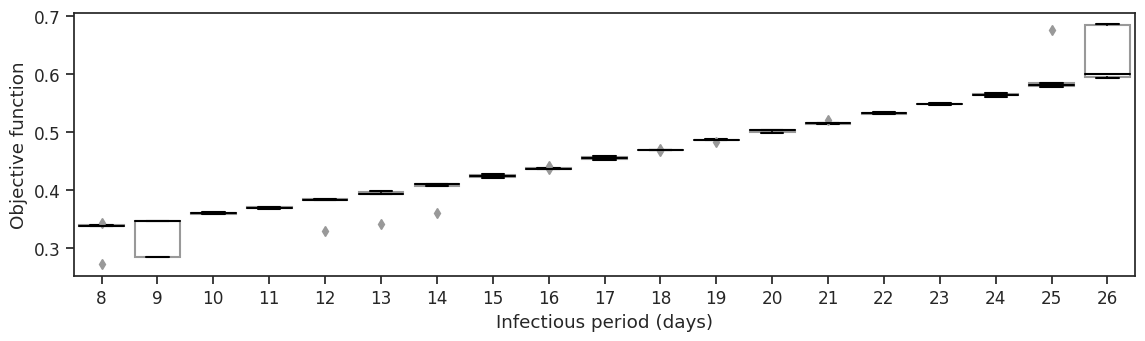

In [10]:
sns.set(font_scale=1.1)
sns.set_style("ticks")

fig, ax = plt.subplots(figsize=(util.centimeter_to_inch(34.8), util.centimeter_to_inch(8.7)))

sns.boxplot(x=df_general_results.days_to_recovery_0.astype(int), y=df_general_results.error, color='white')

plt.ylabel('Objective function')
plt.xlabel('Infectious period (days)')

plt.setp(ax.lines, color='black')
plt.setp(ax.artists, edgecolor = 'black', facecolor='white')

plt.savefig('images/boxplot_sirds_result.eps', bbox_inches="tight")
plt.show()

### Figure 3

In [11]:
def plot_result(y, D_new_deaths, real_new_deaths, real_total_deaths, real_reproduction_number, reproduction_number_sird, real_total_cases, real_new_cases, I_new_cases, dates, save):
    S, I, R, D, I_accumulated = y

    mask_date = mdates.DateFormatter('%m/%Y')
    line_styles= [ '-', '--', ':', '-.', '-']
    sns.set(font_scale=1.1)
    sns.set_style("ticks")
    sns.set_palette(util.get_default_colors_categorical_seaborn())
    fig, ax = plt.subplots(3, 2, figsize=(util.centimeter_to_inch(34.8), util.centimeter_to_inch(26.1)), sharex=False)


    # Plot the data on three separate curves for S(t), I(t), R(t) and D(t)
    sns.lineplot(x=dates, y=S, label='Susceptible', color=util.get_default_colors_categorical_seaborn()[1], legend=True, linestyle=line_styles[0], ax=ax.flatten()[0])
    sns.lineplot(x=dates, y=I, label='Infected', color=util.get_default_colors_categorical_seaborn()[2], legend=True, linestyle=line_styles[1], ax=ax.flatten()[0])
    sns.lineplot(x=dates, y=R, label='Recovered', color=util.get_default_colors_categorical_seaborn()[4], legend=True, linestyle=line_styles[2], ax=ax.flatten()[0])
    sns.lineplot(x=dates, y=D, label='Deceased', color=util.get_default_colors_categorical_seaborn()[3], legend=True, linestyle=line_styles[3], ax=ax.flatten()[0])
    ax.flatten()[0].set_xlabel('Month/Year')
    ax.flatten()[0].xaxis.set_major_formatter(mask_date)
    ax.flatten()[0].tick_params(axis='x', labelrotation=20)
    ax.flatten()[0].set_ylabel('Population')
    ax.flatten()[0].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax.flatten()[0].axvline(valleys[0], 0, 1, linestyle=':', color='gray')
    ax.flatten()[0].axvline(valleys[1], 0, 1, linestyle=':', color='gray')
    ax.flatten()[0].axvline(valleys[2], 0, 1, linestyle=':', color='gray')
    ax.flatten()[0].set_title('a) SIRDS simulation')
    ax.flatten()[0].legend()

     # Plot Rt
    sns.lineplot(x=dates, y=real_reproduction_number, label='Original data', legend=True, linestyle=line_styles[0], ax=ax.flatten()[1])
    sns.lineplot(x=dates, y=reproduction_number_sird, label='Simulation', legend=True, linestyle=line_styles[1], ax=ax.flatten()[1])
    ax.flatten()[1].axhline(1, 0, 1, linestyle='--', color='red')
    ax.flatten()[1].set_xlabel('Month/Year')
    ax.flatten()[1].xaxis.set_major_formatter(mask_date)
    ax.flatten()[1].tick_params(axis='x', labelrotation=20)
    ax.flatten()[1].set_ylabel('$R_{t}$')
    ax.flatten()[1].axvline(valleys[0], 0, 1, linestyle=':', color='gray')
    ax.flatten()[1].axvline(valleys[1], 0, 1, linestyle=':', color='gray')
    ax.flatten()[1].axvline(valleys[2], 0, 1, linestyle=':', color='gray')
    ax.flatten()[1].set_title('b) Effective reproduction number ($R_{t}$)')
    ax.flatten()[1].legend()

    # Plot new cases
    sns.lineplot(x=dates, y=real_new_cases, label='Original data (reported cases)', legend=True, linestyle=line_styles[0], ax=ax.flatten()[2])
    sns.lineplot(x=dates[1:], y=I_new_cases, label='Simulation (infections)', legend=True, linestyle=line_styles[1], ax=ax.flatten()[2])
    ax.flatten()[2].set_xlabel('Month/Year')
    ax.flatten()[2].xaxis.set_major_formatter(mask_date)
    ax.flatten()[2].tick_params(axis='x', labelrotation=20)
    ax.flatten()[2].set_ylabel('Events per 100,000 people')
    ax.flatten()[2].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax.flatten()[2].axvline(valleys[0], 0, 1, linestyle=':', color='gray')
    ax.flatten()[2].axvline(valleys[1], 0, 1, linestyle=':', color='gray')
    ax.flatten()[2].axvline(valleys[2], 0, 1, linestyle=':', color='gray')
    ax.flatten()[2].set_title('c) New cases (infections)')
    ax.flatten()[2].legend()

    # Plot new deaths
    sns.lineplot(x=dates, y=real_new_deaths, label='Original data', legend=True, linestyle=line_styles[0], ax=ax.flatten()[3])
    sns.lineplot(x=dates[1:], y=D_new_deaths, label='Simulation', legend=True, linestyle=line_styles[1], ax=ax.flatten()[3])
    ax.flatten()[3].set_xlabel('Month/Year')
    ax.flatten()[3].xaxis.set_major_formatter(mask_date)
    ax.flatten()[3].tick_params(axis='x', labelrotation=20)
    ax.flatten()[3].set_ylabel('Deaths per 100,000 people')
    ax.flatten()[3].axvline(valleys[0], 0, 1, linestyle=':', color='gray')
    ax.flatten()[3].axvline(valleys[1], 0, 1, linestyle=':', color='gray')
    ax.flatten()[3].axvline(valleys[2], 0, 1, linestyle=':', color='gray')
    ax.flatten()[3].set_title('d) New deaths')
    ax.flatten()[3].legend()

    # Plot total cases
    sns.lineplot(x=dates, y=real_total_cases, label='Original data (reported cases)', legend=True, linestyle=line_styles[0], ax=ax.flatten()[4])
    sns.lineplot(x=dates, y=I_accumulated, label='Simulation (infections)', legend=True, linestyle=line_styles[1], ax=ax.flatten()[4])
    ax.flatten()[4].set_xlabel('Month/Year')
    ax.flatten()[4].xaxis.set_major_formatter(mask_date)
    ax.flatten()[4].tick_params(axis='x', labelrotation=20)
    ax.flatten()[4].set_ylabel('Events per 100,000 people')
    ax.flatten()[4].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax.flatten()[4].axvline(valleys[0], 0, 1, linestyle=':', color='gray')
    ax.flatten()[4].axvline(valleys[1], 0, 1, linestyle=':', color='gray')
    ax.flatten()[4].axvline(valleys[2], 0, 1, linestyle=':', color='gray')
    ax.flatten()[4].set_title('e) Total cases (infections)')
    ax.flatten()[4].legend()

    # Plot total deaths
    sns.lineplot(x=dates, y=real_total_deaths, label='Original data', legend=True, linestyle=line_styles[0], ax=ax.flatten()[5])
    sns.lineplot(x=dates, y=D, label='Simulation', legend=True, linestyle=line_styles[1], ax=ax.flatten()[5])
    ax.flatten()[5].set_xlabel('Month/Year')
    ax.flatten()[5].xaxis.set_major_formatter(mask_date)
    ax.flatten()[5].tick_params(axis='x', labelrotation=20)
    ax.flatten()[5].set_ylabel('Deaths per 100,000 people')
    ax.flatten()[5].axvline(valleys[0], 0, 1, linestyle=':', color='gray')
    ax.flatten()[5].axvline(valleys[1], 0, 1, linestyle=':', color='gray')
    ax.flatten()[5].axvline(valleys[2], 0, 1, linestyle=':', color='gray')
    ax.flatten()[5].set_title('f) Total deaths')
    ax.flatten()[5].legend()

    fig.tight_layout()
    if save:
        plt.savefig('images/sirds_result.eps', bbox_inches="tight", transparent=True)
    plt.show()

def show_parameters(result):
    print('\nParameters')

    print('\ninitial_infected_population: ' + str(round(result.initial_infected_population,4)))
    print('period_in_days: ' + str(round(result.period_in_days,2)))

    print('\ndays_to_recovery_0: ' + str(round(result.days_to_recovery_0,2)))
    print('days_to_recovery_1: ' + str(round(result.days_to_recovery_1,2)))
    print('days_to_recovery_2: ' + str(round(result.days_to_recovery_2,2)))
    print('days_to_recovery_3: ' + str(round(result.days_to_recovery_3,2)))

    print('\ndays_between_infections_0: ' + str(round(result.days_between_infections_0,2)))
    print('days_between_infections_inner_wave_1: ' + str(round(result.days_between_infections_inner_wave_1,2)))
    print('days_between_infections_1: ' + str(round(result.days_between_infections_1,2)))
    print('days_between_infections_2: ' + str(round(result.days_between_infections_2,2)))
    print('days_between_infections_3: ' + str(round(result.days_between_infections_3,2)))

    print('\nR0: ' + str(round(result.days_to_recovery_0/result.days_between_infections_0,2)))
    print('Rp inner wave 1: ' + str(round(result.days_to_recovery_1/result.days_between_infections_inner_wave_1,2)))
    print('Rp1: ' + str(round(result.days_to_recovery_1/result.days_between_infections_1,2)))
    print('Rp2: ' + str(round(result.days_to_recovery_2/result.days_between_infections_2,2)))
    print('Rp3: ' + str(round(result.days_to_recovery_3/result.days_between_infections_3,2)))

    print('\ncase_fatality_probability_0: ' + str(round(result.case_fatality_probability_0,4)))
    print('case_fatality_probability_1: ' + str(round(result.case_fatality_probability_1,4)))
    print('case_fatality_probability_2: ' + str(round(result.case_fatality_probability_2,4)))
    print('case_fatality_probability_3: ' + str(round(result.case_fatality_probability_3,4)))

    print('\nloss_immunity_in_days_0: ' + str(round(result.loss_immunity_in_days_0,2)))
    print('loss_immunity_in_days_1: ' + str(round(result.loss_immunity_in_days_1,2)))
    print('loss_immunity_in_days_2: ' + str(round(result.loss_immunity_in_days_2,2)))
    print('loss_immunity_in_days_3: ' + str(round((result.loss_immunity_in_days_0 + result.loss_immunity_in_days_1 + result.loss_immunity_in_days_2)/3,2)))

    print('\nwave_inner_breakpoint_1: ' + str(round(result.wave_inner_breakpoint_1,2)))
    print('breakpoint_1: ' + str(round(result.breakpoint_1,2)))
    print('breakpoint_2: ' + str(round(result.breakpoint_2,2)))
    print('breakpoint_3: ' + str(round(result.breakpoint_3,2)))

def get_sirds_extras(S, D, N, I_accumulated):
    D_new_deaths = get_new_deaths(D)
    I_new_cases = get_new_cases(I_accumulated)

    reproduction_number_sird = get_effective_reproduction_number(S, N, result.days_to_recovery_0, result.days_between_infections_0, result.breakpoint_1, result.days_to_recovery_1, result.days_between_infections_1, result.breakpoint_2, result.days_to_recovery_2, result.days_between_infections_2, result.breakpoint_3, result.days_to_recovery_3, result.days_between_infections_3, result.wave_inner_breakpoint_1, result.days_between_infections_inner_wave_1)

    return D_new_deaths, reproduction_number_sird, I_new_cases

def show_performance(result, real_new_deaths, D_new_deaths, real_reproduction_number, reproduction_number_sird):
    print('General SSE: '+ str(round(result.error, 3)))

    print('\nNew deaths:')
    sse = mean_squared_error(D_new_deaths, real_new_deaths[1:])
    print('SSE: '+str(round(sse, 3)))
    r2 = r2_score(D_new_deaths, real_new_deaths[1:])
    print('r2: '+str(round(r2, 3)))

    print('\nRt:')

    indices_to_remove = np.argwhere(np.isnan(real_reproduction_number))
    real_reproduction_number = np.delete(real_reproduction_number, indices_to_remove)
    reproduction_number_sird = np.delete(reproduction_number_sird, indices_to_remove)

    sse = mean_squared_error(real_reproduction_number, reproduction_number_sird)
    print('SSE: '+str(round(sse, 3)))
    r2 = r2_score(real_reproduction_number, reproduction_number_sird)
    print('r2: '+str(round(r2, 3)))

General SSE: 0.272

New deaths:
SSE: 0.007
r2: 0.924

Rt:
SSE: 0.037
r2: 0.574

Parameters

initial_infected_population: 0.1255
period_in_days: 964.0

days_to_recovery_0: 8.0
days_to_recovery_1: 8.0
days_to_recovery_2: 8.0
days_to_recovery_3: 8.0

days_between_infections_0: 4.44
days_between_infections_inner_wave_1: 7.82
days_between_infections_1: 6.27
days_between_infections_2: 3.57
days_between_infections_3: 2.39

R0: 1.8
Rp inner wave 1: 1.02
Rp1: 1.28
Rp2: 2.24
Rp3: 3.34

case_fatality_probability_0: 0.0057
case_fatality_probability_1: 0.0057
case_fatality_probability_2: 0.0003
case_fatality_probability_3: 0.0003

loss_immunity_in_days_0: 364.42
loss_immunity_in_days_1: 361.04
loss_immunity_in_days_2: 244.12
loss_immunity_in_days_3: 323.19

wave_inner_breakpoint_1: 86.7
breakpoint_1: 270.79
breakpoint_2: 663.51
breakpoint_3: 793.92


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


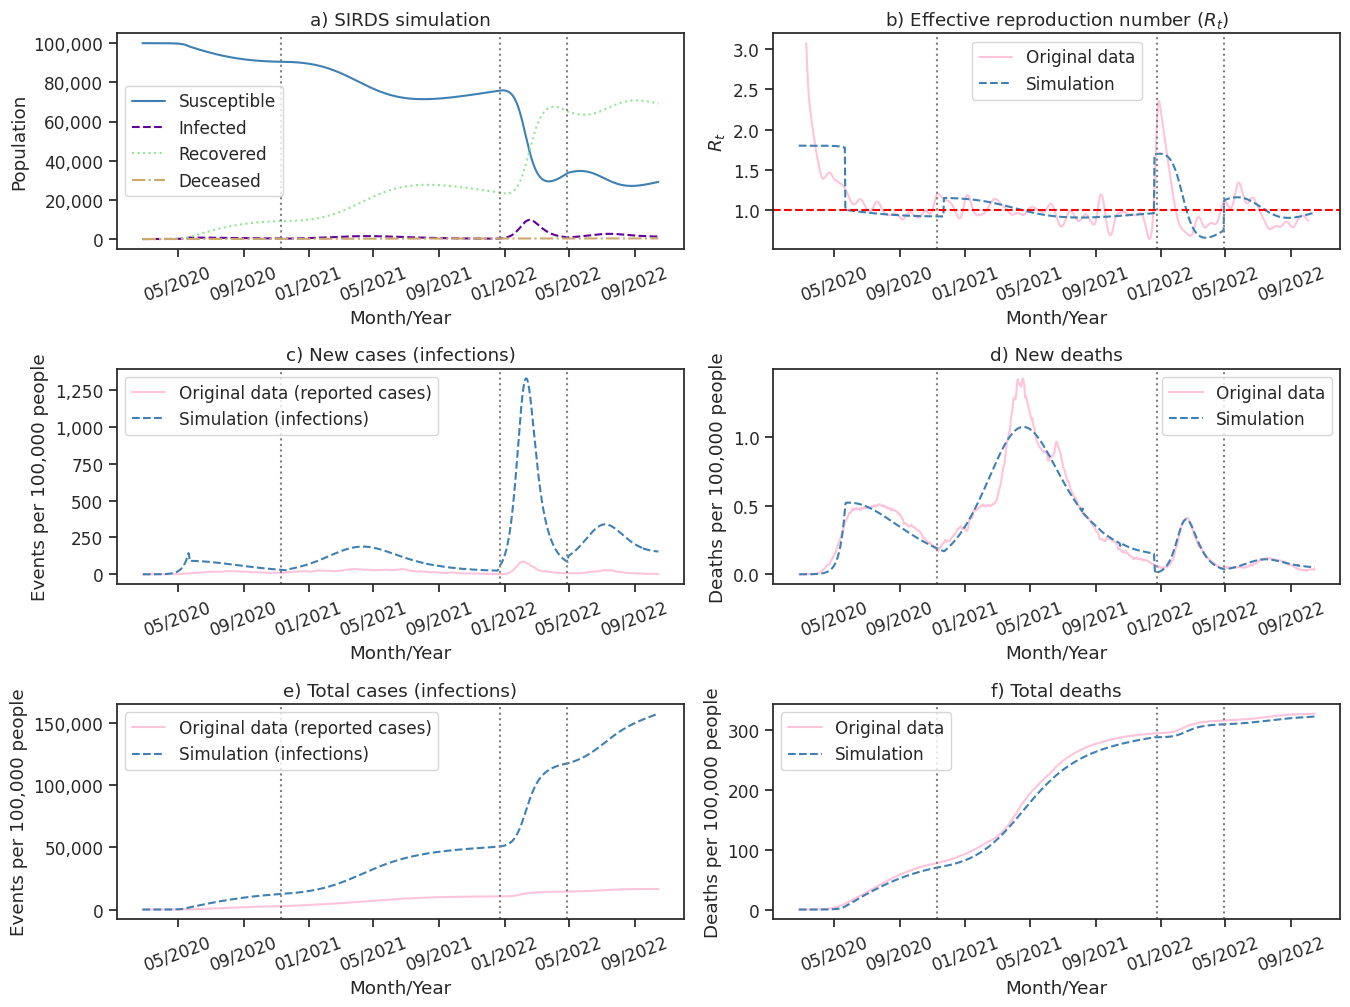

In [12]:
df_best_results = df_best_results.sort_values('error')

for i in range(len(df_best_results[:1])):
    result = df_best_results.iloc[i]

    y = get_sirds(result)
    S, I, R, D, I_accumulated = y
    N = S[0] + I[0] + R[0] + D[0]

    real_new_deaths = df.TAXA_OBITOS_NOVOS_MEDIA_14_DIAS
    real_total_deaths = df.TAXA_OBITOS_ACUMULADOS
    real_new_cases = df.TAXA_CASOS_NOVOS_MEDIA_14_DIAS
    real_total_cases = df.TAXA_CASOS_ACUMULADOS
    real_reproduction_number = df['NUMERO_REPRODUCAO_EFETIVO_MEDIA'].round(6).values

    D_new_deaths, reproduction_number_sird, I_new_cases = get_sirds_extras(S, D, N, I_accumulated)

    show_performance(result, real_new_deaths, D_new_deaths, real_reproduction_number,  reproduction_number_sird)

    show_parameters(result)

    plot_result(y, D_new_deaths, real_new_deaths, real_total_deaths, real_reproduction_number, reproduction_number_sird, real_total_cases, real_new_cases, I_new_cases, df.DATA.values, i==0)

In [16]:
I_accumulated

array([1.25480571e-01, 1.55222236e-01, 1.88096911e-01, 2.24445190e-01,
       2.64631768e-01, 3.09060885e-01, 3.58176464e-01, 4.12474624e-01,
       4.72509662e-01, 5.38881456e-01, 6.12243137e-01, 6.93343194e-01,
       7.83008831e-01, 8.82132730e-01, 9.91723636e-01, 1.11289862e+00,
       1.24684849e+00, 1.39492107e+00, 1.55864666e+00, 1.73963893e+00,
       1.93970303e+00, 2.16091780e+00, 2.40547231e+00, 2.67582064e+00,
       2.97486787e+00, 3.30559237e+00, 3.67117847e+00, 4.07506297e+00,
       4.52164182e+00, 5.01557633e+00, 5.56169261e+00, 6.16515814e+00,
       6.83202287e+00, 7.56965688e+00, 8.38538265e+00, 9.28704195e+00,
       1.02831835e+01, 1.13847741e+01, 1.26031496e+01, 1.39501733e+01,
       1.54385398e+01, 1.70835113e+01, 1.89030098e+01, 2.09149751e+01,
       2.31386415e+01, 2.55952692e+01, 2.83121181e+01, 3.13167703e+01,
       3.46383244e+01, 3.83078979e+01, 4.23636657e+01, 4.68493771e+01,
       5.18090663e+01, 5.72899249e+01, 6.33442551e+01, 7.00390946e+01,
      

In [14]:
df.DATA.values

array(['2020-02-25T00:00:00.000000000', '2020-02-26T00:00:00.000000000',
       '2020-02-27T00:00:00.000000000', '2020-02-28T00:00:00.000000000',
       '2020-02-29T00:00:00.000000000', '2020-03-01T00:00:00.000000000',
       '2020-03-02T00:00:00.000000000', '2020-03-03T00:00:00.000000000',
       '2020-03-04T00:00:00.000000000', '2020-03-05T00:00:00.000000000',
       '2020-03-06T00:00:00.000000000', '2020-03-07T00:00:00.000000000',
       '2020-03-08T00:00:00.000000000', '2020-03-09T00:00:00.000000000',
       '2020-03-10T00:00:00.000000000', '2020-03-11T00:00:00.000000000',
       '2020-03-12T00:00:00.000000000', '2020-03-13T00:00:00.000000000',
       '2020-03-14T00:00:00.000000000', '2020-03-15T00:00:00.000000000',
       '2020-03-16T00:00:00.000000000', '2020-03-17T00:00:00.000000000',
       '2020-03-18T00:00:00.000000000', '2020-03-19T00:00:00.000000000',
       '2020-03-20T00:00:00.000000000', '2020-03-21T00:00:00.000000000',
       '2020-03-22T00:00:00.000000000', '2020-03-23

In [17]:
real_total_cases

0          0.000476
1          0.000476
2          0.000476
3          0.000952
4          0.000952
           ...     
959    16527.249183
960    16529.682716
961    16531.211169
962    16534.350399
963    16535.404898
Name: TAXA_CASOS_ACUMULADOS, Length: 964, dtype: float64

In [18]:
R

array([0.00000000e+00, 1.63833060e-02, 3.44476299e-02, 5.43758454e-02,
       7.63637666e-02, 1.00628441e-01, 1.27408221e-01, 1.56969487e-01,
       1.89609856e-01, 2.25651419e-01, 2.65444860e-01, 3.09392064e-01,
       3.57937184e-01, 4.11559526e-01, 4.70800722e-01, 5.36260564e-01,
       6.08578447e-01, 6.88478063e-01, 7.76781098e-01, 8.74354009e-01,
       9.82166064e-01, 1.10133351e+00, 1.23303177e+00, 1.37857859e+00,
       1.53953394e+00, 1.71749711e+00, 1.91417800e+00, 2.13142209e+00,
       2.37159003e+00, 2.63718499e+00, 2.93079863e+00, 3.25520591e+00,
       3.61365590e+00, 4.01010684e+00, 4.44849131e+00, 4.93302085e+00,
       5.46828676e+00, 6.06017993e+00, 6.71478926e+00, 7.43848710e+00,
       8.23809244e+00, 9.12180456e+00, 1.00992530e+01, 1.11800762e+01,
       1.23746085e+01, 1.36942736e+01, 1.51537240e+01, 1.67677845e+01,
       1.85520953e+01, 2.05233820e+01, 2.27021726e+01, 2.51119979e+01,
       2.77765392e+01, 3.07211775e+01, 3.39740490e+01, 3.75712465e+01,
      

In [19]:
real_total_deaths

0        0.000000
1        0.000000
2        0.000000
3        0.000000
4        0.000000
          ...    
959    326.896216
960    326.926195
961    326.946657
962    326.982346
963    326.986629
Name: TAXA_OBITOS_ACUMULADOS, Length: 964, dtype: float64